# Segundo Desafio - Curso Data Science - Data Properatti


In [1]:
#Se importan los modulos que consideramos necesarios para realizar el levantamiento de la data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# # para usar desde COLAB
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#levantamos cada uno de los archivos 

#para ser usado con la carpeta

data_location = 'properatti_filtrado.csv'
data_original = 'properatti.csv'

#para ser usado con drive

# data_location = '/content/drive/MyDrive/Data Science - TP2/properatti_filtrado.csv'
# data_original = '/content/drive/MyDrive/Data Science - TP2/properatti.csv'

#levantamos la data

data = pd.read_csv(data_location, sep = ',')
data_original = pd.read_csv(data_original, sep = ",")

In [4]:
#limpiamos columnas que quedaron remanentes del analisis anterior (estas no aportan nada para el analisis que queremos hacer)

data_original = data_original.drop(columns = "Unnamed: 0")
data = data.drop(columns = ['Unnamed: 0','Unnamed: 0.1'])
data.shape

(57214, 12)

In [5]:
#Buscamos las caracteristicas principales de la data original, para luego graficar el total de datos que teniamos en el dataset

describe = data_original.describe(include='all')
describeORIGINAL=describe.loc['count'].reset_index()

In [6]:
#Buscamos las caracteristicas principales de la data filtrada, para luego graficar el total de datos que teniamos en el dataset

describeFinal=data.describe(include='all' )
describeFinal=describeFinal.loc['count'].reset_index()

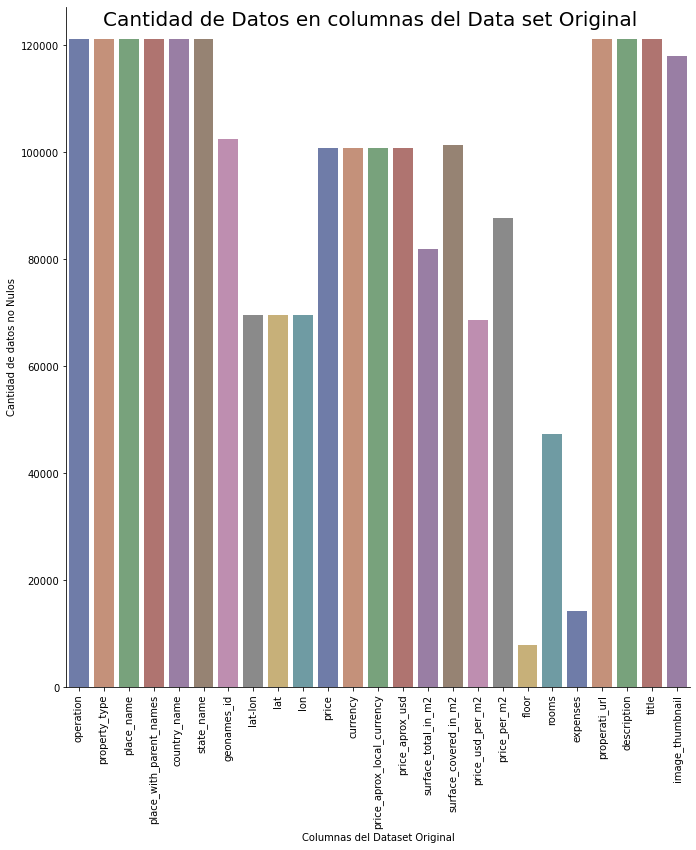

In [7]:
#Realizamos la comparativa grafica entre los datasets, lo primero que queremos ver es cuanta informacion de cada una de las columnas tenemos
#se puede observar que en el dataset original habia faltantes importantes en las columnas, cosa que no pasa en el filtrado, en el cual
#todas las columnas tienen la misma cantidad de informacion

#Codigo grafico Data original

g = sns.catplot(  
    data=describeORIGINAL,
    kind="bar",x='index', y='count' ,
    ci="sd", palette="dark", alpha=.6, height=10
)

#g.despine(left=True)
g.set_axis_labels("Columnas del Dataset Original", "Cantidad de datos no Nulos")

g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation = 90)
g.fig.suptitle("Cantidad de Datos en columnas del Data set Original",fontsize=20)
plt.savefig("cantidad de datos encolumnas data set original.png")

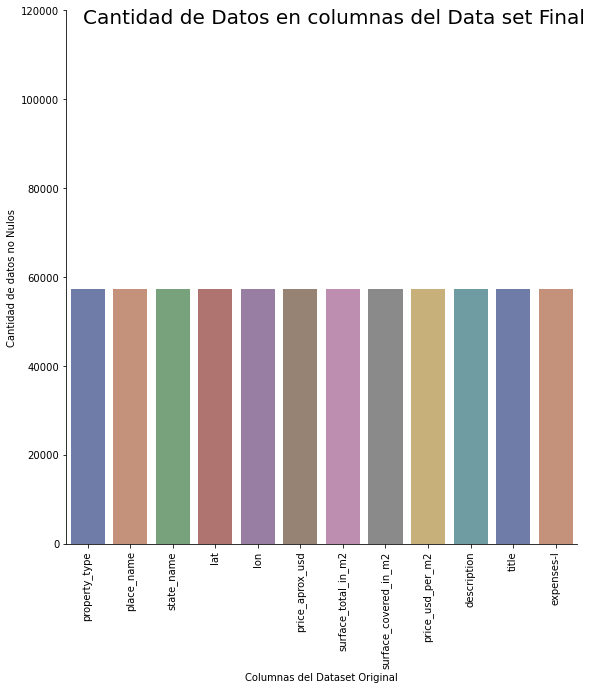

In [8]:
#Codigo grafico Data filtrada
g = sns.catplot(  
    data=describeFinal,
    kind="bar",x='index', y='count' ,
    ci="sd", palette="dark", alpha=.6, height=8
)

#g.despine(left=True)
g.set_axis_labels("Columnas del Dataset Original", "Cantidad de datos no Nulos")

g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation = 90)
g.fig.suptitle("Cantidad de Datos en columnas del Data set Final",fontsize=20, x=0.55)
g.ax.set(ylim=(0,120000))
plt.savefig("cantidad de datos encolumnas dataset filtrado.png")

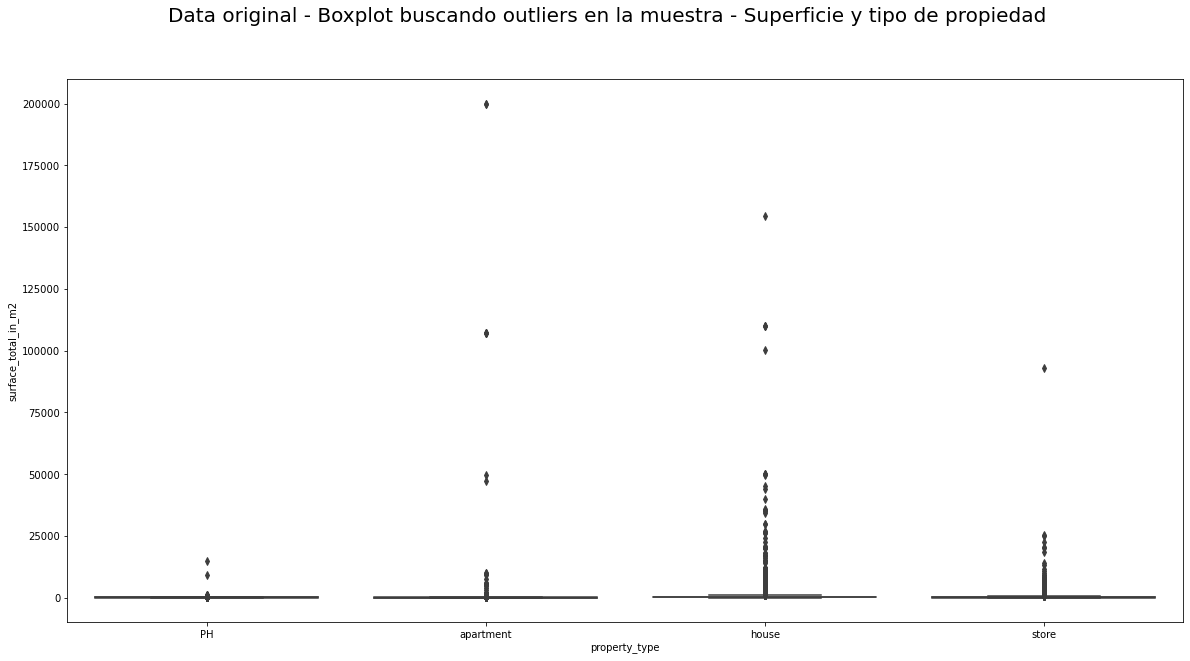

In [9]:
# Para mostrar los resultados obtenidos de la anterior entrega, para s comparar la superficie ey el tipo de propiedad de la data original y la 
# data filtrada, la idea de este grafico es indentificar la cantidad de datos outlier que existian antes y despues de la limpieza de los datos

#Codigo grafico de un boxplot que toma en cuenta el tipo de propiedad y la superficie para la data original

plt.figure(figsize = (20,10))
sns.boxplot(data = data_original, x = "property_type", y = "surface_total_in_m2")
plt.suptitle("Data original - Boxplot buscando outliers en la muestra - Superficie y tipo de propiedad",fontsize=20)
plt.savefig("outliers data original.png")

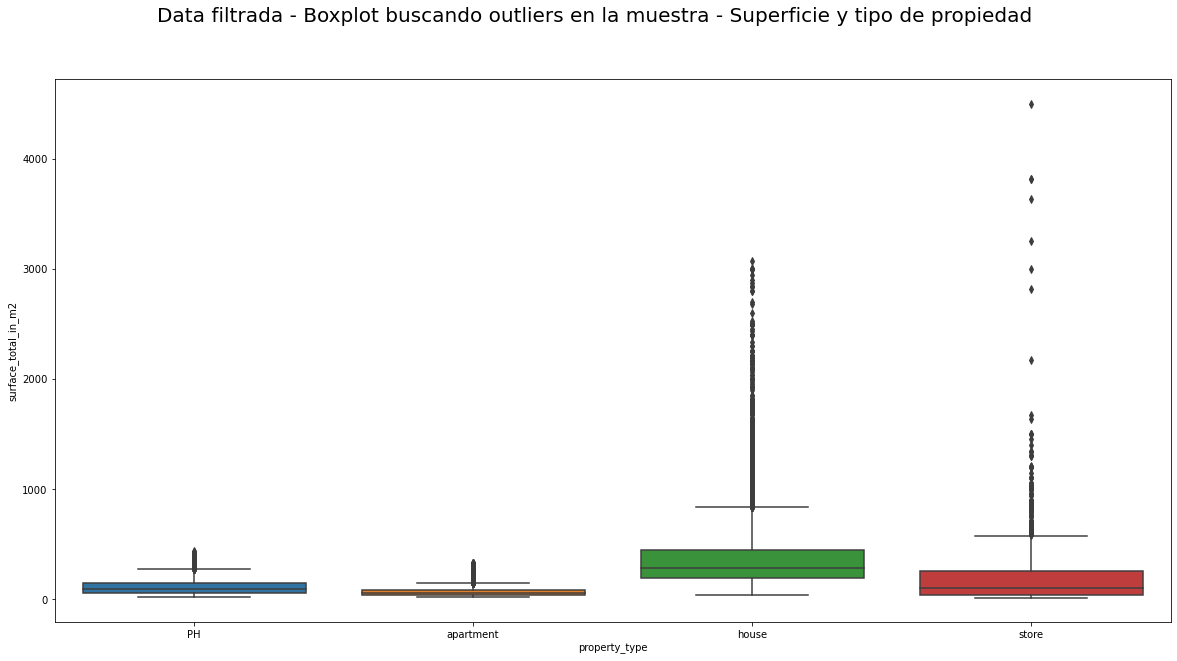

In [10]:
#Codigo grafico de un boxplot que toma en cuenta el tipo de propiedad y la superficie para la data filtrada

plt.figure(figsize = (20,10))
sns.boxplot(data = data, x="property_type", y="surface_total_in_m2")
plt.suptitle("Data filtrada - Boxplot buscando outliers en la muestra - Superficie y tipo de propiedad",fontsize=20)
plt.savefig("outliers data filtrada.png")

COMIENZO DEL MODELADO

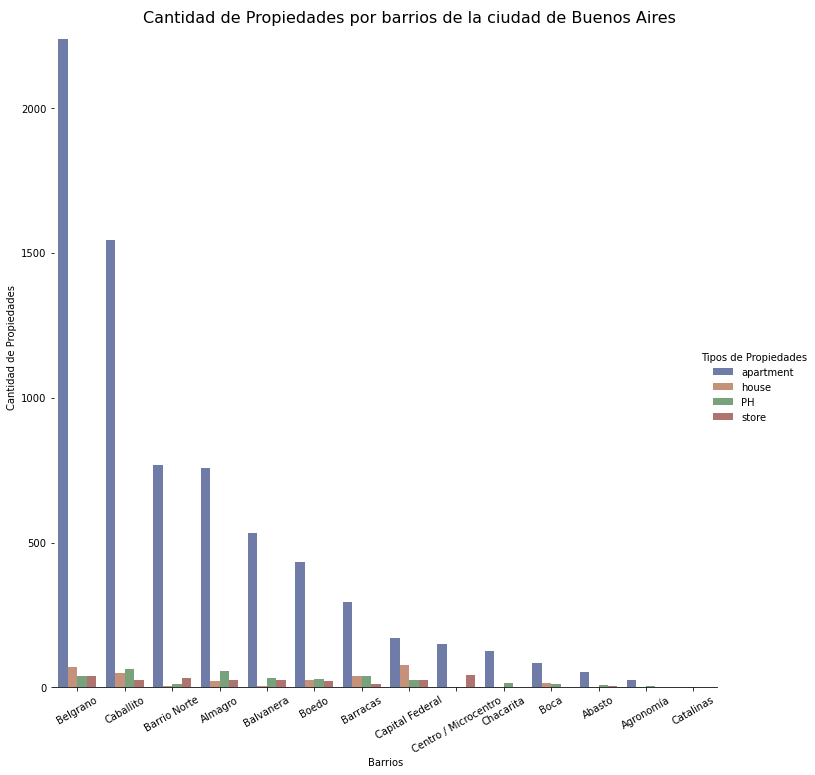

In [11]:
#Para que nuestro modelado sea fiable, decidimos interpretar cual de los datos en las columnas state_name, place_name y property _type se repetian mas.
#Del analisis realizado, en un principio CABA era la variable que mas propiedades traia al dataset, y al analizar mas profundamente se observo que dentro de CABA, el barrio de Belgrano era 
#que mas informacion traia al dataset, luego de identificar esto, se busco que tipo de propiedad aportaba mayor y mejor informacion al dataset, de este analisis se obtuvo que la subclase "Apartment"
#era el que mas informacion traia a este subdataset.

g = sns.catplot(  
    data=((data[(data.state_name=='Capital Federal')].groupby(by=['place_name','property_type'], as_index=False)['expenses-l'].count()).head(50)).sort_values('expenses-l', ascending=False),
    kind="bar",x="place_name", y="expenses-l", hue="property_type",
    ci="sd", palette="dark", alpha=.6, height=10
)

g.despine(left=True)
g.set_axis_labels("Barrios", "Cantidad de Propiedades")
g.legend.set_title("Tipos de Propiedades")
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation = 30)
g.fig.suptitle("Cantidad de Propiedades por barrios de la ciudad de Buenos Aires",fontsize=16)
plt.savefig("propiedades en caba.png")

In [12]:
#Como observamos, Belgrano es el barrio con mas departamentos en el set de datos, es decir, la subclase dentro con mas datos
#que nos permitira crear un modelo mas rebusto de prediccion de precios, es por esto que en lo sucesivo, los modelos de prediccion seran para esta subclase de ubicacion

#codigo que filtra el state_name a Capital federal, el place_name a Belgrano y el property_type a Apartament

data = data[(data.state_name=='Capital Federal')&(data.place_name=='Belgrano')&(data.property_type=='apartment')]

In [13]:
#seleccionamos  las variables que explicaran la variable objetivo conocida como price_aprox_usd, estas variables son las mas relevantes dentro de nuestro
#dataset, aplicando un criterio de seleccion cualitativo (basado en conocimiento del negocio)

data = data[['surface_total_in_m2','expenses-l' ,'price_aprox_usd','lat','lon']]

MODELADO DEL DATASET


In [14]:
#Importamos las librerias necesarias para comenzar el modelado

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [15]:
#obtenemos dummies

dummies = pd.get_dummies(data[list(((data.dtypes.reset_index())[(data.dtypes.reset_index())[0]==object])['index'].values)],drop_first=True)

In [16]:
#escalamos variables numericas

scalerPredict = MinMaxScaler()
scalerPredict.fit(data[list(((data.dtypes.reset_index())[(data.dtypes.reset_index())[0]!=object])['index'].values)])

cuantitativas = pd.DataFrame(scalerPredict.transform( data[list(((data.dtypes.reset_index())[(data.dtypes.reset_index())[0]!=object])['index'].values)] ),
columns = (data[list(((data.dtypes.reset_index())[(data.dtypes.reset_index())[0]!=object])['index'].values)]).columns,
index = (data[list(((data.dtypes.reset_index())[(data.dtypes.reset_index())[0]!=object])['index'].values)]).index)


In [17]:
#componemos variables X y y

X = cuantitativas.join(dummies)
X = X [['surface_total_in_m2', 'lat', 'lon','expenses-l_bajas']]
y = data['price_aprox_usd']

In [18]:
#creamos set de datos de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

# REGRESION LINEAL - MULTIPLE


In [19]:
#iniciamos con nuestro primer modelo que sera una regresion lineal multiple
from sklearn import linear_model
lm = linear_model.LinearRegression(fit_intercept=True)
model_1 = lm.fit(X_train, y_train)
# #predecimos las variables para train y test_size
y_pred_test=lm.predict(X_test)
y_pred_train=lm.predict(X_train)


In [20]:
#imprimimos los resultados de nuestro modelados, y las principales metricas

print('mean_squared_error test: ',metrics.mean_squared_error(y_test, y_pred_test),' mean_squared_error train :' ,metrics.mean_squared_error(y_train, y_pred_train))
print('r cuadrado test: ',metrics.r2_score(y_test, y_pred_test),'r cuadrado traint:', metrics.r2_score(y_train, y_pred_train))#con estas metricas, no tenemos evidencias de que existe un sobreajuste en nuestros datos 
print('raiz de error cuadratico medio: ',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

mean_squared_error test:  12069166873.893042  mean_squared_error train : 13032386761.072535
r cuadrado test:  0.7457908587539762 r cuadrado traint: 0.7441295971832936
raiz de error cuadratico medio:  109859.7600301996


In [21]:
metricas=pd.DataFrame({
   'modelo' :['lineal-sklearn','lineal-sklearn','lineal-sklearn','lineal-sklearn'],
   'metrica': ['mean_squared_error test','mean_squared_error train','r cuadrado test','r cuadrado traint'],
   'valor':[metrics.mean_squared_error(y_test, y_pred_test),metrics.mean_squared_error(y_train, y_pred_train),metrics.r2_score(y_test, y_pred_test),metrics.r2_score(y_train, y_pred_train)]
})

In [22]:
metricas

,modelo,metrica,valor
0,lineal-sklearn,mean_squared_error test,1.206917e+10
1,lineal-sklearn,mean_squared_error train,1.303239e+10
2,lineal-sklearn,r cuadrado test,7.457909e-01
3,lineal-sklearn,r cuadrado traint,7.441296e-01


In [23]:
#imprimios los coeficientes

list(zip(X.columns, lm.coef_))

[('surface_total_in_m2', 967930.9313800057),
 ('lat', 152227.35141652118),
 ('lon', 232790.53435535156),
 ('expenses-l_bajas', 10137.72031299776)]

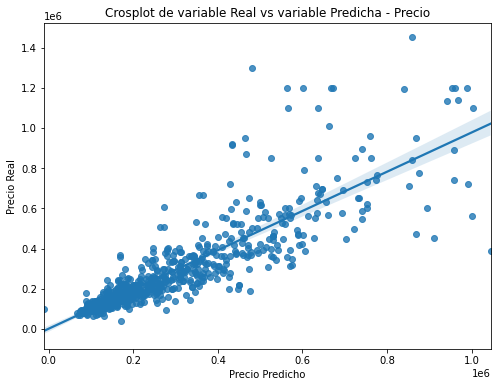

<Figure size 432x288 with 0 Axes>

In [24]:
#graficamos los resultados de y_pred_test y y_test, para ver que tan acertado es el modelo

plt.figure(figsize=(8,6))
ax = sns.regplot(x=pd.DataFrame(y_pred_test, index=np.arange(len(y_pred_test)))[0].values, y=(y_test.reset_index())['price_aprox_usd'].values).set(title='Crosplot de variable Real vs variable Predicha - Precio',
xlabel = "Precio Predicho", ylabel = "Precio Real")
plt.show()
plt.savefig("Crosplot de variable Real vs variable Predicha - Precio.png")

# RIDGE

In [25]:
#iniciamos el modelo  iniciamos le modelo 2, que es una  regresion ridge con noma L2

lm_ridge = linear_model.RidgeCV(alphas=np.arange(0.1,10,step=0.1), normalize=True, cv=3)
best_alpha_model = lm_ridge.fit(X_train, y_train)

In [26]:
print(lm_ridge.alpha_)
'''
mejor alpha 0.1
'''

0.1


'\nmejor alpha 0.1\n'

In [27]:
#predecimos las variables para train y test_size

y_pred_test=best_alpha_model.predict(X_test)
y_pred_train=best_alpha_model.predict(X_train)


In [28]:
#imprimimos los resultados de nuestro modelados, y las principales metricas

print('mean_squared_error test: ',metrics.mean_squared_error(y_test, y_pred_test),' mean_squared_error train :' ,metrics.mean_squared_error(y_train, y_pred_train))
print('r cuadrado test: ',metrics.r2_score(y_test, y_pred_test),'r cuadrado traint:', metrics.r2_score(y_train, y_pred_train))#con estas metricas, no tenemos evidencias de que existe un sobreajuste en nuestros datos 
print('raiz de error cuadratico medio: ',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

mean_squared_error test:  12223098262.204185  mean_squared_error train : 13352907960.118029
r cuadrado test:  0.742548649375131 r cuadrado traint: 0.7378366678976134
raiz de error cuadratico medio:  110558.12164741306


In [29]:
metricas=metricas.append(
pd.DataFrame({
   'modelo' :['lineal-RIDGE','lineal-RIDGE','lineal-RIDGE','lineal-RIDGE'],
   'metrica': ['mean_squared_error test','mean_squared_error train','r cuadrado test','r cuadrado traint'],
   'valor':[metrics.mean_squared_error(y_test, y_pred_test),metrics.mean_squared_error(y_train, y_pred_train),metrics.r2_score(y_test, y_pred_test),metrics.r2_score(y_train, y_pred_train)]
}),ignore_index=True)

In [30]:
metricas

,modelo,metrica,valor
0,lineal-sklearn,mean_squared_error test,1.206917e+10
1,lineal-sklearn,mean_squared_error train,1.303239e+10
2,lineal-sklearn,r cuadrado test,7.457909e-01
3,lineal-sklearn,r cuadrado traint,7.441296e-01
4,lineal-RIDGE,mean_squared_error test,1.222310e+10
5,lineal-RIDGE,mean_squared_error train,1.335291e+10
6,lineal-RIDGE,r cuadrado test,7.425486e-01
7,lineal-RIDGE,r cuadrado traint,7.378367e-01


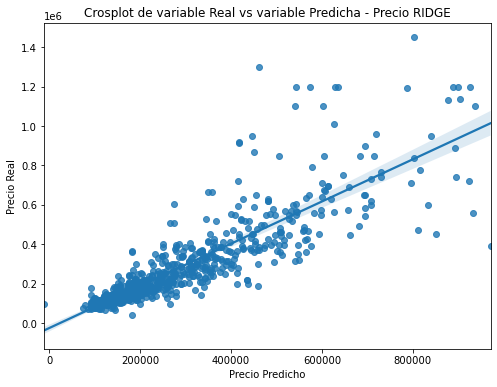

<Figure size 432x288 with 0 Axes>

In [31]:
#graficamos los resultados de y_pred_test y y_test, para ver que tan acertado es el modelo

plt.figure(figsize=(8,6))
ax = sns.regplot(x=pd.DataFrame(y_pred_test, index=np.arange(len(y_pred_test)))[0].values, y=(y_test.reset_index())['price_aprox_usd'].values).set(title='Crosplot de variable Real vs variable Predicha - Precio RIDGE',
xlabel = "Precio Predicho", ylabel = "Precio Real")
plt.show()
plt.savefig("Crosplot de variable Real vs variable Predicha - Precio RIDGE.png")

# LASSO

In [32]:
#ahora vamos con el modelo 3, una regrecion lasso con norma l1

lm_lasso = linear_model.LassoCV(alphas=np.arange(0.1,10,step=0.1), normalize=True, cv=3)
model_lassoB = lm_lasso.fit(X_train, y_train)


In [33]:
print('mejor alpha',lm_lasso.alpha_)

mejor alpha 8.5


In [34]:
#predecimos las variables para train y test_size

y_pred_test=model_lassoB.predict(X_test)
y_pred_train=model_lassoB.predict(X_train)

In [35]:
#imprimimos los resultados de nuestro modelados, y las principales metricas

print('mean_squared_error test: ',metrics.mean_squared_error(y_test, y_pred_test),' mean_squared_error train :' ,metrics.mean_squared_error(y_train, y_pred_train))
print('r cuadrado test: ',metrics.r2_score(y_test, y_pred_test),'r cuadrado traint:', metrics.r2_score(y_train, y_pred_train))#con estas metricas, no tenemos evidencias de que existe un sobreajuste en nuestros datos #Mejor R2
print('raiz de error cuadratico medio: ',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

mean_squared_error test:  12061106749.893345  mean_squared_error train : 13032867438.71702
r cuadrado test:  0.7459606266610495 r cuadrado traint: 0.7441201598342666
raiz de error cuadratico medio:  109823.07020791827


In [36]:
metricas=metricas.append(
pd.DataFrame({
   'modelo' :['lineal-LASSO','lineal-LASSO','lineal-LASSO','lineal-LASSO'],
   'metrica': ['mean_squared_error test','mean_squared_error train','r cuadrado test','r cuadrado traint'],
   'valor':[metrics.mean_squared_error(y_test, y_pred_test),metrics.mean_squared_error(y_train, y_pred_train),metrics.r2_score(y_test, y_pred_test),metrics.r2_score(y_train, y_pred_train)]
}),ignore_index=True)

In [37]:
list(zip(X.columns, lm.coef_))

[('surface_total_in_m2', 967930.9313800057),
 ('lat', 152227.35141652118),
 ('lon', 232790.53435535156),
 ('expenses-l_bajas', 10137.72031299776)]

In [38]:
metricas

,modelo,metrica,valor
0,lineal-sklearn,mean_squared_error test,1.206917e+10
1,lineal-sklearn,mean_squared_error train,1.303239e+10
2,lineal-sklearn,r cuadrado test,7.457909e-01
3,lineal-sklearn,r cuadrado traint,7.441296e-01
4,lineal-RIDGE,mean_squared_error test,1.222310e+10
5,lineal-RIDGE,mean_squared_error train,1.335291e+10
6,lineal-RIDGE,r cuadrado test,7.425486e-01
7,lineal-RIDGE,r cuadrado traint,7.378367e-01
8,lineal-LASSO,mean_squared_error test,1.206111e+10
9,lineal-LASSO,mean_squared_error train,1.303287e+10


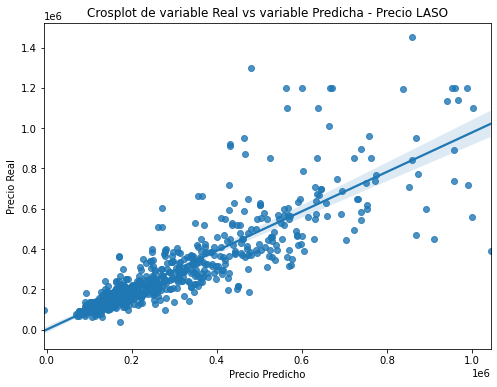

<Figure size 432x288 with 0 Axes>

In [39]:
#graficamos los resultados de y_pred_test y y_test, para ver que tan acertado es el modelo

plt.figure(figsize=(8,6))
ax = sns.regplot(x=pd.DataFrame(y_pred_test, index=np.arange(len(y_pred_test)))[0].values, y=(y_test.reset_index())['price_aprox_usd'].values).set(title='Crosplot de variable Real vs variable Predicha - Precio LASO',xlabel = "Precio Predicho", ylabel = "Precio Real")
plt.show()
plt.savefig("Crosplot de variable Real vs variable Predicha - Precio LASO.png")

# OLS CON STATMODELS

In [40]:
#importamos las librerias statmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [41]:
#trabajamos el cuarto modelo con OLS STATMODELS, decidimos utilizar un modelo de regresion multiple

X_train=sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1054.
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:15:39   Log-Likelihood:                -18995.
No. Observations:                1454   AIC:                         3.800e+04
Df Residuals:                    1449   BIC:                         3.803e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.634e+05   4

In [42]:
#predecimos las variables 

X_test=sm.add_constant(X_test)
y_pred_test=model.predict(X_test)

In [43]:
print('mean_squared_error test: ',metrics.mean_squared_error(y_test, y_pred_test),' mean_squared_error train :' ,metrics.mean_squared_error(y_train, y_pred_train))
print('r cuadrado test: ',metrics.r2_score(y_test, y_pred_test),'r cuadrado traint:', metrics.r2_score(y_train, y_pred_train))#con estas metricas, no tenemos evidencias de que existe un sobreajuste en nuestros datos 
print('raiz de error cuadratico medio: ',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

mean_squared_error test:  12069166873.893042  mean_squared_error train : 13032867438.71702
r cuadrado test:  0.7457908587539762 r cuadrado traint: 0.7441201598342666
raiz de error cuadratico medio:  109859.7600301996


In [44]:
metricas=metricas.append(
pd.DataFrame({
   'modelo' :['lineal-OLS ','lineal-OLS ','lineal-OLS ','lineal-OLS '],
   'metrica': ['mean_squared_error test','mean_squared_error train','r cuadrado test','r cuadrado traint'],
   'valor':[metrics.mean_squared_error(y_test, y_pred_test),metrics.mean_squared_error(y_train, y_pred_train),metrics.r2_score(y_test, y_pred_test),metrics.r2_score(y_train, y_pred_train)]
}),ignore_index=True)

In [45]:
metricas

,modelo,metrica,valor
0,lineal-sklearn,mean_squared_error test,1.206917e+10
1,lineal-sklearn,mean_squared_error train,1.303239e+10
2,lineal-sklearn,r cuadrado test,7.457909e-01
3,lineal-sklearn,r cuadrado traint,7.441296e-01
4,lineal-RIDGE,mean_squared_error test,1.222310e+10
5,lineal-RIDGE,mean_squared_error train,1.335291e+10
6,lineal-RIDGE,r cuadrado test,7.425486e-01
7,lineal-RIDGE,r cuadrado traint,7.378367e-01
8,lineal-LASSO,mean_squared_error test,1.206111e+10
9,lineal-LASSO,mean_squared_error train,1.303287e+10


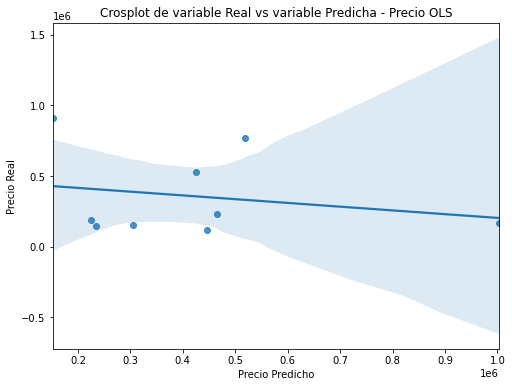

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=pd.DataFrame(y_pred_test, index=np.arange(len(y_pred_test)))[0].values, y=(y_test.reset_index())['price_aprox_usd'].values).set(title='Crosplot de variable Real vs variable Predicha - Precio OLS',
xlabel = "Precio Predicho", ylabel = "Precio Real")
plt.show()
plt.savefig("Crosplot de variable Real vs variable Predicha - Precio OLS.png")

# COMPARATIVO DE LOS MODELOS

C:\Users\TZ182CG\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


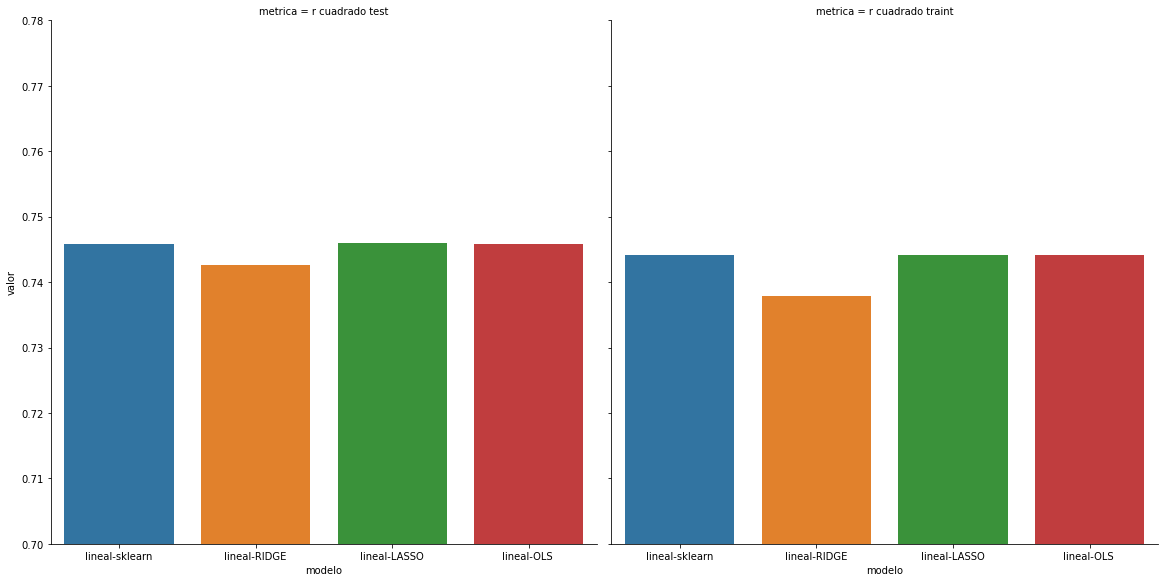

In [47]:
grafico=sns.catplot(col="metrica", x="modelo",
    y="valor", sharex=False, legend_out=True,height=8,
    kind="bar",  data=metricas[metricas['metrica'].str.contains('r cuadrado')]).set(ylim=(0.7,0.78))
grafico.savefig('R2')

C:\Users\TZ182CG\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


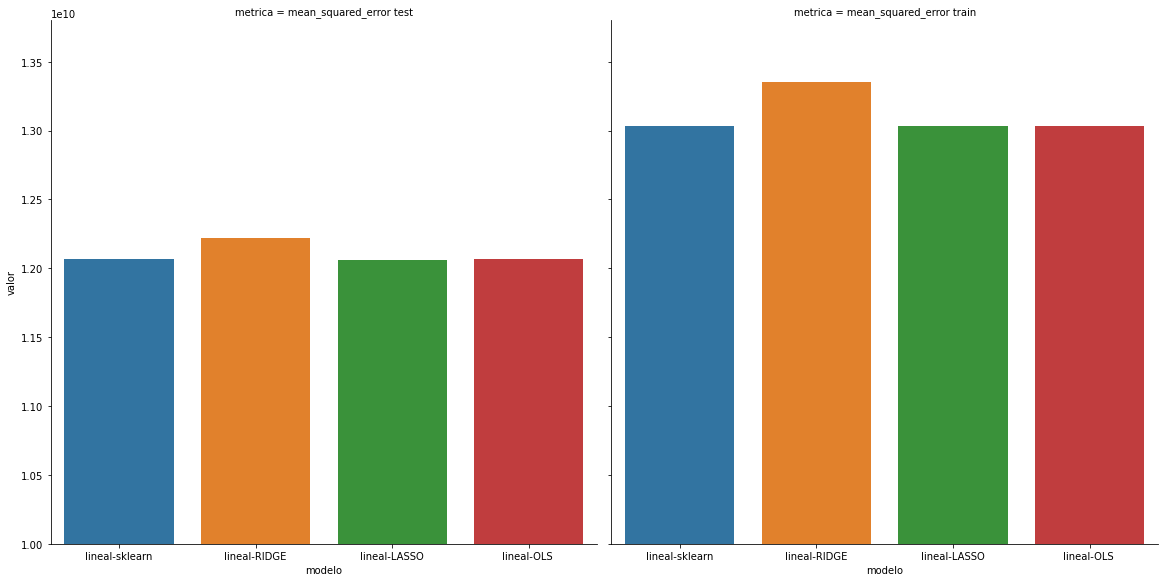

In [48]:
grafico=sns.catplot(col="metrica", x="modelo",
    y="valor", sharex=False, legend_out=True,height=8,
    kind="bar",  data=metricas[~metricas['metrica'].str.contains('r cuadrado')]).set(ylim=(10000000000,13800000000))
grafico.savefig('RMD')